In [1]:
import pandas as pd
from mplsoccer import VerticalPitch, FontManager, PyPizza
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import Radar
import textwrap

robotto_thin = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf')
custom_cmap = LinearSegmentedColormap.from_list('greens', ['#edfff2', '#0d773d'], N=100)

In [2]:
df_stats = pd.read_parquet('player_stats_112_2022.parquet')
df_events = pd.read_parquet('opta_events_112_2022.parquet')
df_events['set_piece_taken'] = (df_events['free_kick_taken'] |
                                df_events['free_kick'] | # includes tap pass can exclude with df['assisted'].isnull()
                                df_events['corner_taken'] |
                                df_events['shot_corner_direct'] |
                                df_events['goalkeeper_goal_kick'] |
                                df_events['kick_off'] |
                                df_events['throw_in'] |
                                (df_events['type_name'] == 'foul_throw_in')
                               )

# Pitch pass locations for Mike Trésor

In [3]:
df_player_events = df_events[((df_events['player_id'] == 437748) &
                              (df_events['type_name'] == 'pass') &
                              (df_events['outcome'] == 1) & 
                              (df_events['set_piece_taken'].isnull())
                             )].copy()

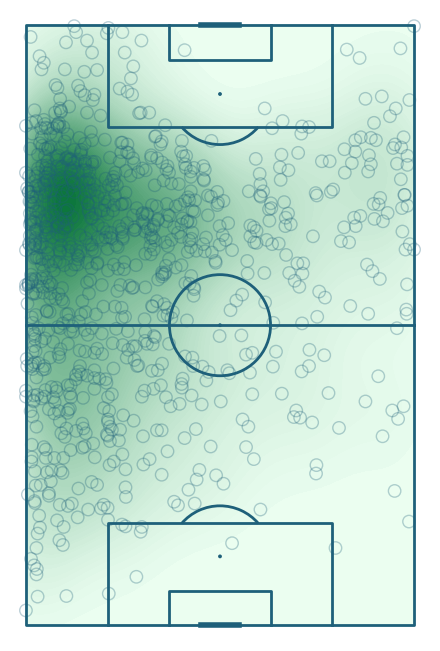

In [4]:
p = VerticalPitch(pitch_type='opta', line_zorder=3, line_color='#1E607A')
fig, ax = p.draw(figsize=(4.5, 4.5/p.ax_aspect))
p.scatter(df_player_events.x, df_player_events.y, alpha=0.3, s=80, marker='o', zorder=2, ec='#1E607A', fc='None', ax=ax)
p.kdeplot(df_player_events.x, df_player_events.y, fill=True, levels=100, cmap=custom_cmap, zorder=1, thresh=0, ax=ax)
fig.savefig('mike_tresor_pitch.png')

# Radar for Mike Trésor

In [5]:
cols = ['playing_time_90s', 'per_90_minutes_g_pk', 'per_90_minutes_npxg', 'standard_sh_90',
        'per_90_minutes_ast', 'per_90_minutes_xag',
        'per_90_minutes_npxg_xag', 'sca_sca90',
        'att', 'total_cmp_percent', 'progression_prgp', 'progression_prgc',
        'take_ons_succ', 'touches_att_pen', 'progression_prgr', 'tackles_tklw', 'int',
        'blocks_blocks', 'clr', 'aerial_duels_won']
params = ["npxG", "Non-Penalty Goals", "xA", "Key Passes", "Through Balls",
          "Progressive Passes", "Shot-Creating Actions", "Goal-Creating Actions",
          "Dribbles Completed", "Pressure Regains", "Touches In Box", "Miscontrol"]
df_stats[cols] = df_stats[cols].astype(float)
stats_to_standardize = [c for c in cols if '90' not in c and 'total_cmp' not in c and 'player' not in cols]
df_stats[stats_to_standardize] = df_stats[stats_to_standardize].div(df_stats['playing_time_90s'], axis='rows')
df_comparison = df_stats.loc[(df_stats['pos'].isin(['FW,MF', 'MF,FW'])) & (df_stats.playing_time_min.astype(float) >= 560), cols].copy()
df_player_stats = df_stats.loc[df_stats['player'] == 'Mike Trésor']
lower_bound = df_comparison.quantile(0.05).values[1:]
upper_bound = df_comparison.quantile(0.95).values[1:]
player_values = df_player_stats[cols].iloc[0].values[1:]
df_percentile = df_comparison.rank(pct=True).copy()
player_percentile = (df_percentile.loc[df_percentile.index == df_player_stats.index[0], cols].iloc[0].values[1:] * 100).round(0).astype(int)
params = ['Non-Penalty Goals', 'Non-Penalty xG', 'Shots', 'Assists', 'xAG', 'npxG + xAG', 'Shot-Creating Actions',
          'Passes Attempted', 'Pass Completion %', 'Progressive Passes', 'Progressive Carries', 'Successful Take-Ons',
          'Touches (Att Pen)', 'Progressive Passes Rec', 'Tackles', 'Interceptions', 'Blocks', 'Clearances', 'Aerials Won']

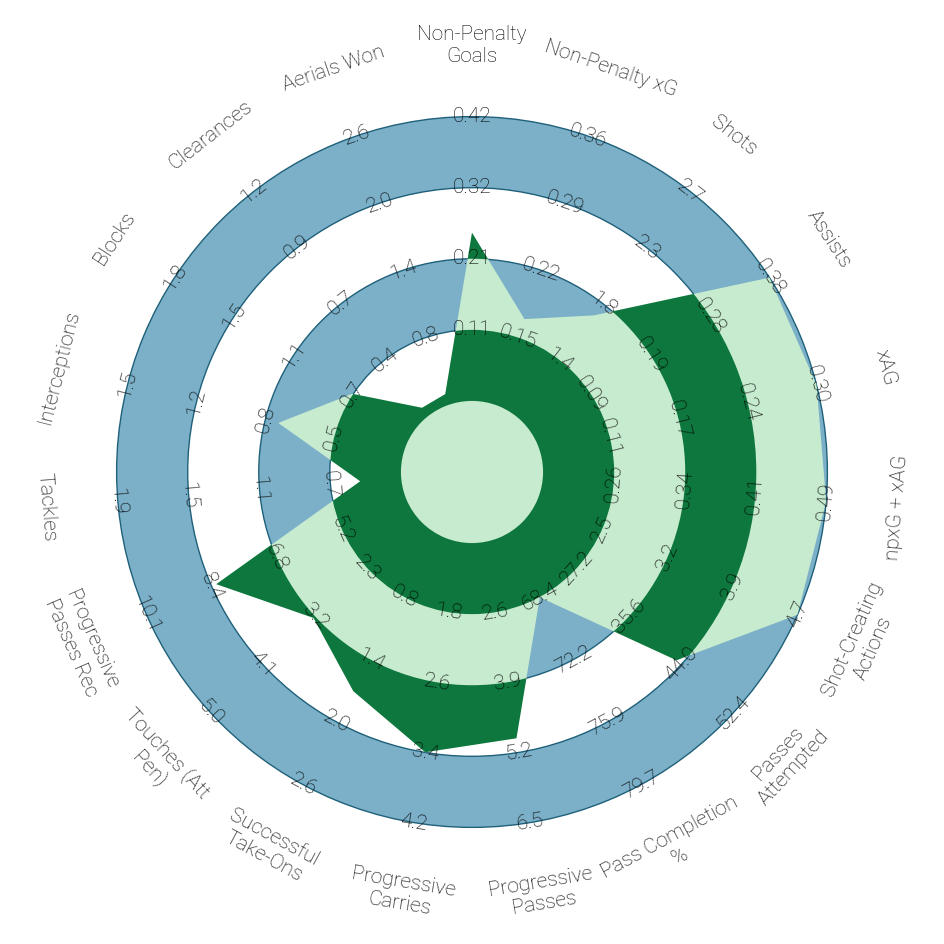

In [6]:
radar = Radar(params, lower_bound, upper_bound, num_rings=4, ring_width=1, center_circle_radius=1)
fig, ax = radar.setup_axis()
rings_inner = radar.draw_circles(ax=ax, facecolor='#7cb0c8', edgecolor='#1e607a')
radar_output = radar.draw_radar(player_values, ax=ax, kwargs_radar={'facecolor': '#c7ebcf'}, kwargs_rings={'facecolor': '#0D773D'})
radar_poly, rings_outer, vertices = radar_output
range_labels = radar.draw_range_labels(ax=ax, fontsize=15, fontproperties=robotto_thin.prop)
param_labels = radar.draw_param_labels(ax=ax, fontsize=15, fontproperties=robotto_thin.prop)
fig.savefig('mike_tresor_radar.png', bbox_inches='tight', pad_inches=0)

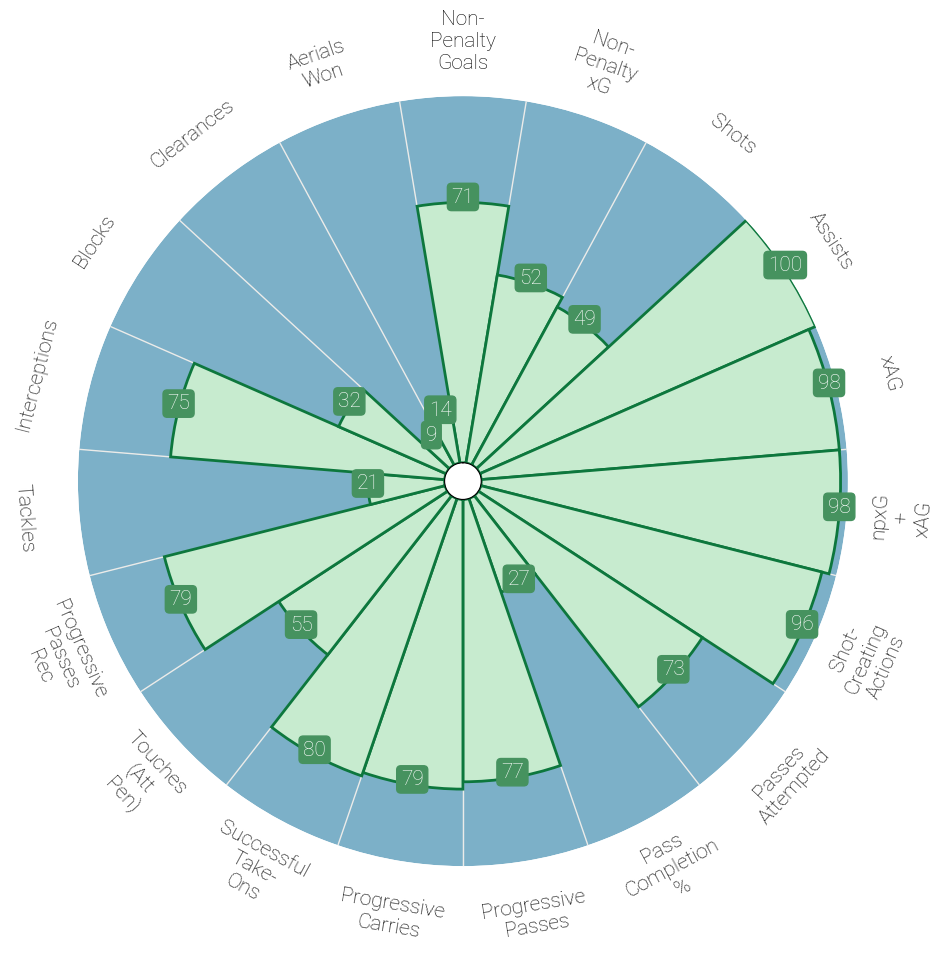

In [7]:
slice_colors = ["#c7ebcf"] * 19
text_colors = ['white'] * 19
param_formatted = ['\n'.join(textwrap.wrap(label, True, break_long_words=False)) for label in params]
baker = PyPizza(params=param_formatted, background_color="None", straight_line_color="#EBEBE9",
                straight_line_lw=1, last_circle_lw=0, other_circle_lw=0, inner_circle_size=5)
fig, ax = baker.make_pizza(player_percentile, figsize=(10, 10), color_blank_space=['#7cb0c8']*19, slice_colors=slice_colors,
                           value_colors=text_colors, value_bck_colors=slice_colors,
                           blank_alpha=1,
                           param_location=115,
                           kwargs_slices=dict(edgecolor='#0D773D', zorder=2, linewidth=2),
                           kwargs_params=dict(fontsize=15, fontproperties=robotto_thin.prop, va="center"),
                           kwargs_values=dict(fontsize=15, fontproperties=robotto_thin.prop, zorder=3,
                                              bbox=dict(edgecolor='#0D773D', color='#46925f', boxstyle="round,pad=0.2", lw=1)
                                             )
                          )
fig.savefig('mike_tresor_pizza.png', bbox_inches='tight', pad_inches=0)